# Summary

Starting point for a supervised learning model for Ookla speed tiles. The data comes from a combination of 
Ookla Open Data speed tests and Statistics Canada information, including 2016 census population data and census boundaries (shapefiles). 


In [9]:
import sys
sys.path.append("..")

In [10]:
import src.config

In [11]:
from src.datasets.loading import statcan, ookla

In [12]:
import numpy as np 
import pandas as pd
import geopandas as gp

In [13]:
from sklearn import preprocessing, pipeline, compose
from sklearn import linear_model, model_selection, svm
from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.metrics import silhouette_score,calinski_harabasz_score,davies_bouldin_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV

In [14]:
import matplotlib.pyplot as plt 
import plotly.express as px
import pickle

## Load 
Load some of the available data. The census population data and StatCan boundaries are automatically loaded from 
the StatCan website. The overlays and tile geometries/speeds need to pre-computed and saved to the overlays directory and data directories. 

### Load All Unique Tile Gemoetries

In [22]:
ookla_tiles = ookla.canada_tiles()

### Load Census Population Information

In [23]:
da_pops = statcan.dissemination_areas_populations()

/home/jovyan/src/datasets/loading/statcan.py:234: DtypeWarning:

Columns (3,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.



### Labelling Tiles
Generate labels from geometric overlay of the Ookla tiles and Statistics Canada Dissemination Areas (DA). 
Label each tile with the information from the StatCan areas based on which DA the tile overlaps the most with.

In [24]:
o = gp.read_file(src.config.OVERLAYS_DIR / 'tile_das_overlay') #this can take a few minutes to load.
tile_da_label = o.dropna(subset=['DAUID','quadkey']).sort_values(by=['quadkey','tile_frac'],ascending=False).drop_duplicates(subset='quadkey', keep='first')
tile_da_label['quadkey'] = tile_da_label['quadkey'].astype(int)
tile_da_label['DAUID'] = tile_da_label['DAUID'].astype(int)

### Speed Test Data
Load in the previous 4 quarters of data. Since we're currently in Q3 of 2022, the most recent quarter is Q2 
so we can slice the files listed to grab those. Subsequently, we'll calculate weighted averages for individual tiles and use those as representative speeds for our model.

In [25]:
last_4_quarters = ookla.speed_data(ookla.available_files().loc[('fixed',2021,3):('fixed',2022,2)].path)

In [26]:
down = last_4_quarters.groupby('quadkey').apply(lambda s:np.average(s.avg_d_kbps, weights=s.tests)).rename('avg_d_kbps')
up = last_4_quarters.groupby('quadkey').apply(lambda s:np.average(s.avg_u_kbps, weights=s.tests)).rename('avg_u_kbps')
tests = last_4_quarters.groupby('quadkey')['tests'].sum()
devices = last_4_quarters.groupby('quadkey')['devices'].sum()
last4_agg = pd.concat([down, up, tests, devices],axis=1)

### Merge All The Data
It's a bit messy, but we're merging several tables and removing a few of the redundant or non-useful 
columns as we go through. At the end the `features_table` variable will have all of the 
tiles within census areas labelled by what type of Census Subdivision, Dissemination Area, Population Centre, etc. they are in, as well as population information for the DA (smallest area with populations available) and the speed test averages over the last 4 quarters.

In [27]:
## merge dissemination area (DA) populations with ookla tiles (already combined with other statcan data)
features_table = tile_da_label.merge(da_pops, on='DAUID', how='left')
features_table['DAPOP'] = features_table['DAPOP'].fillna(0).astype(int)
del features_table['GEO_NAME']
features_table = pd.DataFrame(features_table)
del features_table['geometry']
features_table['POP_DENSITY'] = features_table['DAPOP']/features_table['das_area']*1000**2 #people per square kilometer

# take all ookla tiles, merge the speeds data and tile labels and populations
features_table = ookla_tiles.merge(last4_agg, on='quadkey').merge(features_table, on='quadkey')

# compute spatial joins to identify if area is a population centre
pop_info = statcan.boundary('population_centres').to_crs('epsg:4326')
pop_info = pop_info[['PCUID', 'PCNAME', 'PCTYPE', 'PCPUID', 'PCCLASS', 'geometry']] ##removes some redundant cols from DAs
features_table = features_table.sjoin(pop_info, how='left')
del features_table['index_right']
features_table = features_table.sort_values(by=['PCUID','quadkey']).drop_duplicates(subset=['quadkey']) #keep tiles where overlap was true

### Categorize All the Columns
All the columns from our joins above can be roughly split into categories based on the type of 
data and how you might use them in a simple supervised learning problem. These are broken down as follows:

In [28]:
pkey = 'quadkey'
geometry = 'geometry'
id_and_names = ['DAUID', 'CDUID', 'CDNAME', 'CCSUID', 'CSDNAME', 'CMAUID', 'CMAPUID', 'CMANAME', 
'CCSNAME', 'CSDUID', 'ERUID', 'ERNAME', 'CTUID', 'CTNAME', 'ADAUID', 
'PCUID', 'PCNAME', 'PCPUID', 'SACCODE',] ##SACCODE is half a category half ID values

categorical_labels = [
    #'PRUID', #PRUID is redundant with PRNAME
    'PRNAME', 'CDTYPE', 
    'CSDTYPE',  
    'SACTYPE', 
    'CMATYPE', 'PCTYPE', 'PCCLASS',
]
numerical_vars = [
    'tests', 'devices',
    'das_area', 'tile_area', 'tile_frac',  'das_frac', 
    'DAPOP','POP_DENSITY'
]
target_vars = ['avg_d_kbps', 'avg_u_kbps']

In [29]:
col_subset = [pkey] + categorical_labels + numerical_vars + target_vars
features_table.loc[:,col_subset].set_index('quadkey')

PRNAME CDTYPE   
quadkey                                                                     
302231302213222                                            Ontario     RM  \
302231302230013                                            Ontario     RM   
302231302230022                                            Ontario     RM   
302231302230023                                            Ontario     RM   
302231302230030                                            Ontario     RM   
...                                                            ...    ...   
303303002030011  Newfoundland and Labrador / Terre-Neuve-et-Lab...    CDR   
303303002032102  Newfoundland and Labrador / Terre-Neuve-et-Lab...    CDR   
303303002122000  Newfoundland and Labrador / Terre-Neuve-et-Lab...    CDR   
303303002122001  Newfoundland and Labrador / Terre-Neuve-et-Lab...    CDR   
303303002122003  Newfoundland and Labrador / Terre-Neuve-et-Lab...    CDR   

                CSDTYPE SACTYPE CMATYPE PCTYPE PCCLASS  tests  devices   
quadkey                                                                  
302231302213222       T       1       B      2       2     12        8  \
302231302230013       T       1       B      2       2     32        7   
302231302230022       T       1       B      2       2      4        2   
302231302230023       T       1       B      2       2    128       13   
302231302230030       T       1       B      2       2      1        1   
...                 ...     ...     ...    ...     ...    ...      ...   
303303002030011       T       5     NaN    NaN     NaN      1        1   
303303002032102       T       5     NaN    NaN     NaN      1        1   
303303002122000       T       7     NaN    NaN     NaN      1        1   
303303002122001       T       7     NaN    NaN     NaN     11        3   
303303002122003       T       7     NaN    NaN     NaN      1        1   

                     das_area      tile_area  tile_frac  das_frac  DAPOP   
quadkey                                                                    
302231302213222  4.489387e+06  205331.876525   0.917314  0.041955   1420  \
302231302230013  5.391016e+06  205402.379648   0.894827  0.034094   1030   
302231302230022  1.030375e+07  205472.906899   0.611219  0.012189    505   
302231302230023  1.765704e+06  205472.906900   0.871430  0.101407    795   
302231302230030  5.391016e+06  205437.640257   0.939933  0.035818   1030   
...                       ...            ...        ...       ...    ...   
303303002030011  1.777728e+07  179010.291685   0.579748  0.005838    350   
303303002032102  1.777728e+07  179287.191779   0.533632  0.005382    350   
303303002122000  1.194131e+06  179256.404038   0.574792  0.086285    150   
303303002122001  1.194131e+06  179256.404038   1.000000  0.150114    150   
303303002122003  1.194131e+06  179287.191779   0.912957  0.137072    150   

                 POP_DENSITY     avg_d_kbps     avg_u_kbps  
quadkey                                                     
302231302213222   316.301553  201908.916667   23286.833333  
302231302230013   191.058601  393118.031250  169457.281250  
302231302230022    49.011263   19284.750000    4310.750000  
302231302230023   450.245236   10499.585938    1387.898438  
302231302230030   191.058601     535.000000     889.000000  
...                      ...            ...            ...  
303303002030011    19.688054   43155.000000    1901.000000  
303303002032102    19.688054    1634.000000     690.000000  
303303002122000   125.614323   37799.000000   12489.000000  
303303002122001   125.614323   40291.272727    9116.000000  
303303002122003   125.614323   37499.000000     436.000000  

[338872 rows x 17 columns]

In [30]:
print(features_table.dtypes)

quadkey           int64
geometry       geometry
avg_d_kbps      float64
avg_u_kbps      float64
tests             int64
devices           int64
DAUID             int64
PRUID            object
PRNAME           object
CDUID            object
CDNAME           object
CDTYPE           object
CCSUID           object
CCSNAME          object
CSDUID           object
CSDNAME          object
CSDTYPE          object
ERUID            object
ERNAME           object
SACCODE          object
SACTYPE          object
CMAUID           object
CMAPUID          object
CMANAME          object
CMATYPE          object
CTUID            object
CTNAME           object
ADAUID           object
das_area        float64
tile_area       float64
tile_frac       float64
das_frac        float64
DAPOP             int64
POP_DENSITY     float64
PCUID            object
PCNAME           object
PCTYPE           object
PCPUID           object
PCCLASS          object
dtype: object


In [32]:
features_table

quadkey                                           geometry   
32915   302231302213222  POLYGON ((-80.02441 43.64800, -80.01892 43.648...  \
67352   302231302230013  POLYGON ((-80.05188 43.64005, -80.04639 43.640...   
185959  302231302230022  POLYGON ((-80.06836 43.63210, -80.06287 43.632...   
38693   302231302230023  POLYGON ((-80.06287 43.63210, -80.05737 43.632...   
52422   302231302230030  POLYGON ((-80.05737 43.63608, -80.05188 43.636...   
...                 ...                                                ...   
283489  303303002030011  POLYGON ((-53.33313 46.73986, -53.32764 46.739...   
258525  303303002032102  POLYGON ((-53.32764 46.70597, -53.32214 46.705...   
214589  303303002122000  POLYGON ((-53.26172 46.70974, -53.25623 46.709...   
285249  303303002122001  POLYGON ((-53.25623 46.70974, -53.25073 46.709...   
335093  303303002122003  POLYGON ((-53.25623 46.70597, -53.25073 46.705...   

           avg_d_kbps     avg_u_kbps  tests  devices     DAUID PRUID   
32915   201908.916667   23286.833333     12        8  35240570    35  \
67352   393118.031250  169457.281250     32        7  35240571    35   
185959   19284.750000    4310.750000      4        2  35240629    35   
38693    10499.585938    1387.898438    128       13  35240573    35   
52422      535.000000     889.000000      1        1  35240571    35   
...               ...            ...    ...      ...       ...   ...   
283489   43155.000000    1901.000000      1        1  10010735    10   
258525    1634.000000     690.000000      1        1  10010735    10   
214589   37799.000000   12489.000000      1        1  10010734    10   
285249   40291.272727    9116.000000     11        3  10010734    10   
335093   37499.000000     436.000000      1        1  10010734    10   

                                                   PRNAME CDUID  ...   
32915                                             Ontario  3524  ...  \
67352                                             Ontario  3524  ...   
185959                                            Ontario  3524  ...   
38693                                             Ontario  3524  ...   
52422                                             Ontario  3524  ...   
...                                                   ...   ...  ...   
283489  Newfoundland and Labrador / Terre-Neuve-et-Lab...  1001  ...   
258525  Newfoundland and Labrador / Terre-Neuve-et-Lab...  1001  ...   
214589  Newfoundland and Labrador / Terre-Neuve-et-Lab...  1001  ...   
285249  Newfoundland and Labrador / Terre-Neuve-et-Lab...  1001  ...   
335093  Newfoundland and Labrador / Terre-Neuve-et-Lab...  1001  ...   

            tile_area tile_frac  das_frac DAPOP POP_DENSITY PCUID PCNAME   
32915   205331.876525  0.917314  0.041955  1420  316.301553  0001  Acton  \
67352   205402.379648  0.894827  0.034094  1030  191.058601  0001  Acton   
185959  205472.906899  0.611219  0.012189   505   49.011263  0001  Acton   
38693   205472.906900  0.871430  0.101407   795  450.245236  0001  Acton   
52422   205437.640257  0.939933  0.035818  1030  191.058601  0001  Acton   
...               ...       ...       ...   ...         ...   ...    ...   
283489  179010.291685  0.579748  0.005838   350   19.688054   NaN    NaN   
258525  179287.191779  0.533632  0.005382   350   19.688054   NaN    NaN   
214589  179256.404038  0.574792  0.086285   150  125.614323   NaN    NaN   
285249  179256.404038  1.000000  0.150114   150  125.614323   NaN    NaN   
335093  179287.191779  0.912957  0.137072   150  125.614323   NaN    NaN   

       PCTYPE  PCPUID PCCLASS  
32915       2  350001       2  
67352       2  350001       2  
185959      2  350001       2  
38693       2  350001       2  
52422       2  350001       2  
...       ...     ...     ...  
283489    NaN     NaN     NaN  
258525    NaN     NaN     NaN  
214589    NaN     NaN     NaN  
285249    NaN     NaN     NaN  
335093    NaN     NaN     NaN  

[338872 rows x 39 columns]

In [33]:
with open('data.pickle', 'wb') as f:
    pickle.dump(features_table, f)

# Clustering for Census Divisions and Census Subdivision Types. 


In [34]:
features_table.columns

Index(['quadkey', 'geometry', 'avg_d_kbps', 'avg_u_kbps', 'tests', 'devices',
       'DAUID', 'PRUID', 'PRNAME', 'CDUID', 'CDNAME', 'CDTYPE', 'CCSUID',
       'CCSNAME', 'CSDUID', 'CSDNAME', 'CSDTYPE', 'ERUID', 'ERNAME', 'SACCODE',
       'SACTYPE', 'CMAUID', 'CMAPUID', 'CMANAME', 'CMATYPE', 'CTUID', 'CTNAME',
       'ADAUID', 'das_area', 'tile_area', 'tile_frac', 'das_frac', 'DAPOP',
       'POP_DENSITY', 'PCUID', 'PCNAME', 'PCTYPE', 'PCPUID', 'PCCLASS'],
      dtype='object')

In [35]:
cluster_features = ['CDTYPE', 'CSDTYPE']
cluster_data = features_table[cluster_features + target_vars]
cluster_data = cluster_data.sample(n=10000)  # fit using a random subset of data to save time

In [17]:
# Use only Alberta data
cluster_features = ['CDTYPE', 'CSDTYPE']

cluster_data = features_table[features_table['PRUID'] == '48']
cluster_data = cluster_data[cluster_features + target_vars]

with open('data_AB.pickle', 'wb') as f:
    pickle.dump(cluster_data, f)
    #Read pickle file as 
    #cluster_data = pd.read_pickle(r'data_AB.pickle')


NameError: name 'features_table' is not defined

In [16]:
cluster_features = ['CDTYPE', 'CSDTYPE']
cluster_data = pd.read_pickle(r'data_AB.pickle')


In [17]:
# clustering = OPTICS(min_samples=50, xi=0.01, metric='euclidean')
clustering = KMeans(n_clusters=4)

colTransformer = compose.ColumnTransformer(
    [(f"{cat}",preprocessing.OneHotEncoder(),[cat]) for cat in set(categorical_labels) & set(cluster_features)] \
    + [(f"{num}", preprocessing.StandardScaler(), [num]) for num in set(numerical_vars) & set(cluster_features)] 
    #+ [(f"{y}_stdscaler", preprocessing.StandardScaler(), [y]) for y in target_vars]
)
clustering_pipe = pipeline.Pipeline([
    ('preprocess',colTransformer),
    ('clustering', clustering)
])

clustering_pipe.fit(cluster_data)

labels = clustering.labels_

print(labels)



/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[2 2 2 ... 1 1 1]


Using GridSearchCV to find optimal values:

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

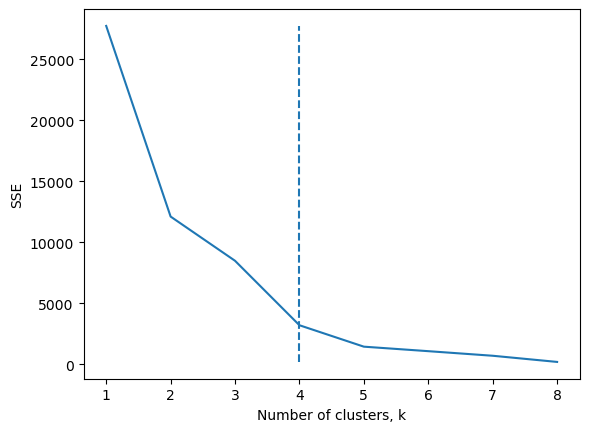

In [18]:
# KMeans Elbow-method
colTransformer = compose.ColumnTransformer(
    [(f"{cat}",preprocessing.OneHotEncoder(),[cat]) for cat in set(categorical_labels) & set(cluster_features)] \
    + [(f"{num}", preprocessing.StandardScaler(), [num]) for num in set(numerical_vars) & set(cluster_features)] 
    #+ [(f"{y}_stdscaler", preprocessing.StandardScaler(), [y]) for y in target_vars]
)

sse = {}
for k in range(1, 9):
    clustering = KMeans(n_clusters=k)


    clustering_pipe = pipeline.Pipeline([
        ('preprocess',colTransformer),
        ('clustering', clustering)
    ])
    clustering_pipe.fit(cluster_data)

    sse[k] = clustering.inertia_


# plot SSE vs. k with elbow point
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of clusters, k')
plt.ylabel('SSE')
plt.vlines(4, ymin=min(sse.values()), ymax=max(sse.values()), linestyle='--') 
plt.show()



6 was found to be a good value while using a subset of the data

In [19]:
clustering = KMeans(n_clusters=5)

colTransformer = compose.ColumnTransformer(
    [(f"{cat}",preprocessing.OneHotEncoder(),[cat]) for cat in set(categorical_labels) & set(cluster_features)] \
    + [(f"{num}", preprocessing.StandardScaler(), [num]) for num in set(numerical_vars) & set(cluster_features)] 
    #+ [(f"{y}_stdscaler", preprocessing.StandardScaler(), [y]) for y in target_vars]
)
clustering_pipe = pipeline.Pipeline([
    ('preprocess',colTransformer),
    ('clustering', clustering)
])

clustering_pipe.fit(cluster_data)

labels = clustering.labels_

cluster_data['kmeans_cluster_label'] = labels

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [20]:
def scatter_3d(df, x:str='CDTYPE', y:str='CSDTYPE', z:str='avg_d_kbps', color:str='kmeans_cluster_label'):
    fig = px.scatter_3d(df, x=x, y=y, z=z, color=color)
    fig.show()

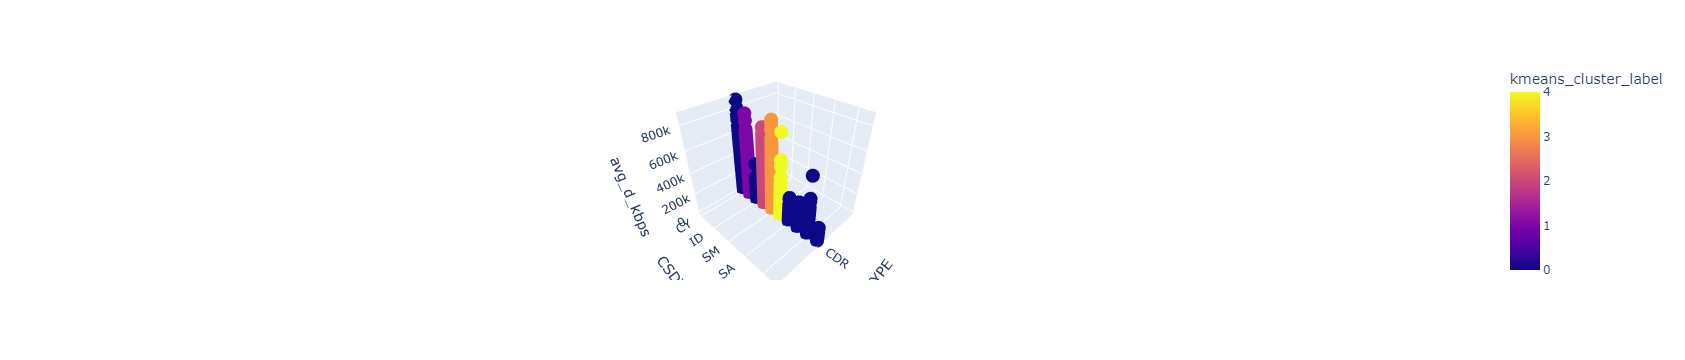

In [21]:
# cluster_data

scatter_3d(cluster_data, x='CDTYPE', y='CSDTYPE', z='avg_d_kbps', color='kmeans_cluster_label')

### Interpretations

- The orange cluster represents a large number of areas all have weak connectivity. This cluster should likely receive the most attention for policy direction.

- 

- There is a huge variation in all area types. This indicates that no matter what type of area we consider (such as rural/urban areas) there are both areas with high speeds and low speeds. We confirm the findings of regression analysis that area type is not a very good indicator of internet connectivity.  


Let's try DBSCAN


In [36]:
#DBSCAN


eps = 1.4 
min_samples = 80
clustering = DBSCAN(eps=eps, min_samples=min_samples)

# create a pipeline with a preprocessing step and the OPTICS clustering step
pipe = pipeline.Pipeline([
    ('preprocess', colTransformer), # add a StandardScaler preprocessing step
    ('clustering', clustering)
])

pipe.fit(cluster_data)

labels = clustering.labels_


#kernel dies unexpectedly when working with only Alberta data

In [37]:
counts = {}

# Loop through the list and count the occurrences of each element
for l in labels:
    counts[l] = list(labels).count(l)

# Print the dictionary
print(counts)

{0: 158, 1: 348, 2: 465, 3: 87, 4: 703, 5: 337, 6: 815, -1: 1157, 7: 113, 8: 183, 9: 81, 10: 548, 11: 244, 12: 780, 13: 161, 14: 651, 15: 146, 16: 97, 17: 200, 18: 236, 19: 190, 20: 184, 21: 180, 22: 165, 23: 118, 24: 279, 25: 575, 26: 227, 27: 297, 28: 87, 29: 89, 30: 99}


In [38]:
len(counts)

32

In [39]:
clustering.labels_


array([ 0,  1,  2, ...,  4, 25,  1])

In [58]:
# Finding the best parameters for DBSCAN

# define parameter ranges
eps_range = np.linspace(0.01, 2.0, num=10)
min_samples_range = range(2,5)

# perform grid search
best_score = -1
best_params = {}
for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        pipe = pipeline.Pipeline([
            ('preprocess', colTransformer), # add a StandardScaler preprocessing step
            ('clustering', dbscan)
        ])
        pipe.fit(cluster_data)
        if len(set(dbscan.labels_)) > 1 and len(set(dbscan.labels_)) <100:
            score = calinski_harabasz_score(pipe.named_steps["preprocess"].transform(cluster_data).toarray(), dbscan.labels_)
            print('(eps, min_samples) = ', (eps, min_samples))
            print('score = ', score)
            print('best_params = ', best_params)
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

# print best parameters
print('Best parameters:', best_params)


(eps, min_samples) =  (0.01, 2)
score =  134923.18165519956
best_params =  {}
(eps, min_samples) =  (0.01, 3)
score =  73940.67236311482
best_params =  {'eps': 0.01, 'min_samples': 2}
(eps, min_samples) =  (0.01, 4)
score =  45327.84152900036
best_params =  {'eps': 0.01, 'min_samples': 2}
(eps, min_samples) =  (0.23111111111111113, 2)
score =  134923.18165519956
best_params =  {'eps': 0.01, 'min_samples': 2}
(eps, min_samples) =  (0.23111111111111113, 3)
score =  73940.67236311482
best_params =  {'eps': 0.01, 'min_samples': 2}
(eps, min_samples) =  (0.23111111111111113, 4)
score =  45327.84152900036
best_params =  {'eps': 0.01, 'min_samples': 2}
(eps, min_samples) =  (0.45222222222222225, 2)
score =  134923.18165519956
best_params =  {'eps': 0.01, 'min_samples': 2}
(eps, min_samples) =  (0.45222222222222225, 3)
score =  73940.67236311482
best_params =  {'eps': 0.01, 'min_samples': 2}
(eps, min_samples) =  (0.45222222222222225, 4)
score =  45327.84152900036
best_params =  {'eps': 0.01, 

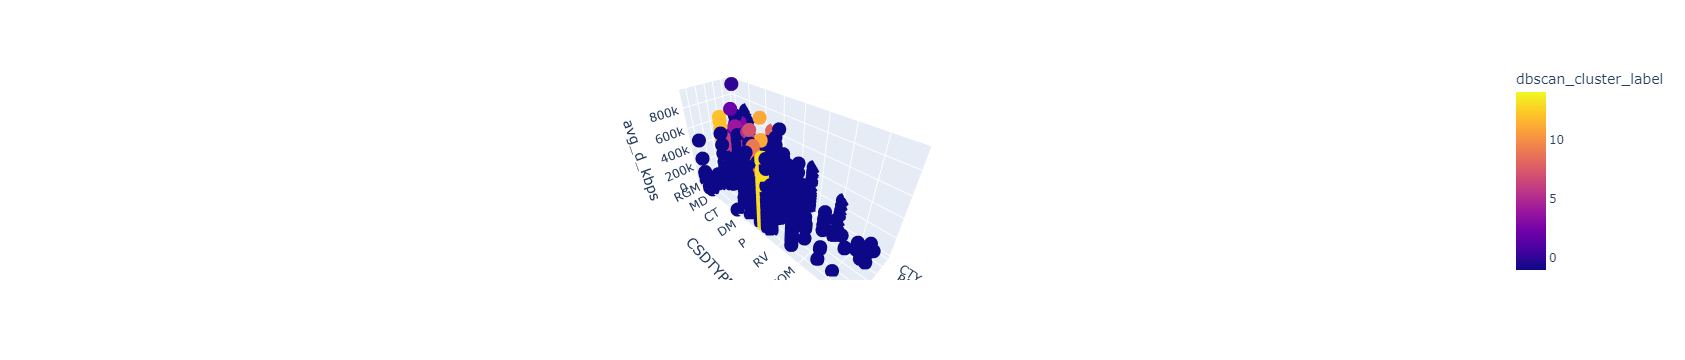

In [59]:
# dbscan = DBSCAN(eps=best_params['eps'], min_samples=int(best_params['min_samples']))
dbscan = DBSCAN(eps=0.1, min_samples=200)
pipe = pipeline.Pipeline([
    ('preprocess', colTransformer), # add a StandardScaler preprocessing step
    ('clustering', dbscan)
])
pipe.fit(cluster_data)
        
cluster_data['dbscan_cluster_label'] = dbscan.labels_
scatter_3d(cluster_data, x='CDTYPE', y='CSDTYPE', z='avg_d_kbps', color='dbscan_cluster_label')

Clustering results of the DBSCAN algorithm are not very conclusive when applied on the data with . Clusterings favored by the silhouette_score and calinski_harabasz_score validation indices tend to generate 60+ clusters, whereas davies_bouldin_score favors results with 2 clusters. Both are extreme cases and do not give interpretable results. 



OPTICS


In [48]:
#OPTICS

params = {'min_samples': range(2, 10), 'xi': np.linspace(0.01, 0.1, num=10)}

# create an OPTICS object
clustering = OPTICS(min_samples=2, xi=0.5, metric='l2')

# create a pipeline with a preprocessing step and the OPTICS clustering step
pipe = pipeline.Pipeline([
    ('preprocess', colTransformer), # add a StandardScaler preprocessing step
    ('clustering', clustering)
])

pipe.fit(cluster_data)

labels = clustering.labels_

# Getting a divide by zero exception. 

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_optics.py:932: RuntimeWarning:

divide by zero encountered in divide



In [104]:
!pwd

/home/jovyan/notebooks
